## Dataset Overview

The dataset used in this project is **`training.1600000.processed.noemoticon.csv`**, also known as the **Sentiment140 dataset**.  
It contains **1.6 million tweets** labeled for sentiment analysis. Each tweet is annotated as **positive (4)** or **negative (0)** based on its sentiment.

Since the full dataset is too large for local processing, we created a **balanced sample of 50,000 tweets** (25,000 positive and 25,000 negative) and saved it as  
`sentiment140_50k.csv`.

### Columns
- **target** — Sentiment label (`0` = negative, `1` = positive after conversion)  
- **id** — Unique identifier for the tweet  
- **date** — Date and time of the tweet  
- **flag** — Query flag (not relevant)  
- **user** — Username of the tweet author  
- **text** — The actual tweet content

# Loading datased

In [1]:
import pandas as pd

df = pd.read_csv("sentiment140_50k.csv")
df.head()

,target,id,date,flag,user,text
0,1,2064229792,Sun Jun 07 05:38:57 PDT 2009,NO_QUERY,PinoyTarsier,@indykitty *hug indykitty* sleep tight indy...
1,0,2063435330,Sun Jun 07 02:38:52 PDT 2009,NO_QUERY,Hannah_oxberry,@Shough yeah I feel really bad for them tryin...
2,0,2251087443,Sat Jun 20 02:23:50 PDT 2009,NO_QUERY,meabhaline,@embeep sorry about your sadness I'll be home...
3,0,2066987792,Sun Jun 07 11:32:31 PDT 2009,NO_QUERY,PDKG,Couldn't spend time with the family cuz of wor...
4,1,1557513350,Sun Apr 19 04:34:04 PDT 2009,NO_QUERY,eulaivi,is new on twitter


# Preprocessing

**Dropping Irrelevant Columns**

Columns `id`, `date`, `flag`, and `user` are not related to sentiment, so we drop them and keep only `text` and `target`.

In [2]:
df = df.drop(columns=["id", "date", "flag", "user"])
df.head()

,target,text
0,1,@indykitty *hug indykitty* sleep tight indy...
1,0,@Shough yeah I feel really bad for them tryin...
2,0,@embeep sorry about your sadness I'll be home...
3,0,Couldn't spend time with the family cuz of wor...
4,1,is new on twitter


In [3]:
# Count of each sentiment
df["target"].value_counts()

target
1    25000
0    25000
Name: count, dtype: int64

In [4]:
df["target"] = df["target"].replace(4, 1)
df["target"].value_counts()

target
1    25000
0    25000
Name: count, dtype: int64

In [5]:
df["target"].dtype

dtype('int64')

In [6]:
df["text"].head(10)

0      @indykitty *hug indykitty* sleep tight indy... 
1    @Shough yeah I feel really bad for them  tryin...
2    @embeep sorry about your sadness  I'll be home...
3    Couldn't spend time with the family cuz of wor...
4                                   is new on twitter 
5    just want you all to kno how amazing Jesus is....
6    @FollowKayleigh AAwww.. Xd.. you wasn't in his...
7                    welp, bedtime for me guys. night 
8    @iceicebabyice yo I have been not following yo...
9                                    Three more days. 
Name: text, dtype: object

## Text Preprocessing

Common preprocessing steps for tweets:

- Convert text to lowercase  
- Remove URLs (`http://...`)  
- Remove mentions (`@username`)  
- Remove punctuation and special characters  
- Remove extra whitespace  

These steps help clean the text and make it ready for modeling.

In [7]:
# This function preprocesses a tweet by:
# 1. Converting text to lowercase
# 2. Removing URLs
# 3. Removing mentions (@username)
# 4. Removing punctuation and special characters
# 5. Removing extra whitespace
import re

def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = " ".join(text.split())  # remove extra spaces
    return text

In [8]:
df["text"] = df["text"].apply(preprocess_text)
df.head()

,target,text
0,1,hug indykitty sleep tight indy
1,0,yeah i feel really bad for them trying my best...
2,0,sorry about your sadness ill be home next week...
3,0,couldnt spend time with the family cuz of work...
4,1,is new on twitter


## Tweet tokenization and padding

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 10000  # maximum number of words
max_length = 50     # maximum tweet length
oov_token = "<OOV>"

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df["text"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["text"])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

padded_sequences.shape  # (num_samples, max_length)

D:\Conda\envs\base_ml_env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


(50000, 50)

**Text to Sequences**

We converted the preprocessed tweets into **sequences of integers** using Keras Tokenizer, and applied **padding** so all sequences have the same length. This prepares the data for input into a TensorFlow neural network.

# Building and compiling the model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential([
    Embedding(vocab_size, 16),  # maps integer tokens to 16-dim vectors
    GlobalAveragePooling1D(),                            # averages token vectors to fixed-size
    Dense(16, activation='relu'),                        # hidden layer to learn patterns
    Dense(1, activation='sigmoid')                       # output layer for binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train-Test split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df["target"].values, test_size=0.2, random_state=42
)

# Train the model

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6605 - loss: 0.6154 - val_accuracy: 0.7334 - val_loss: 0.5356
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7641 - loss: 0.4969 - val_accuracy: 0.7650 - val_loss: 0.4954
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7935 - loss: 0.4516 - val_accuracy: 0.7314 - val_loss: 0.5438
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8050 - loss: 0.4298 - val_accuracy: 0.7736 - val_loss: 0.4883
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8144 - loss: 0.4153 - val_accuracy: 0.7609 - val_loss: 0.4984
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8257 - loss: 0.3985 - val_accuracy: 0.7634 - val_loss: 0.5059
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8285 - loss: 0.3906 - val_accuracy: 0.7489 - val_loss: 0.5326
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8318 - loss: 

# Evaluate the model

In [13]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7624 - loss: 0.5270
Test Loss: 0.5270
Test Accuracy: 0.7624


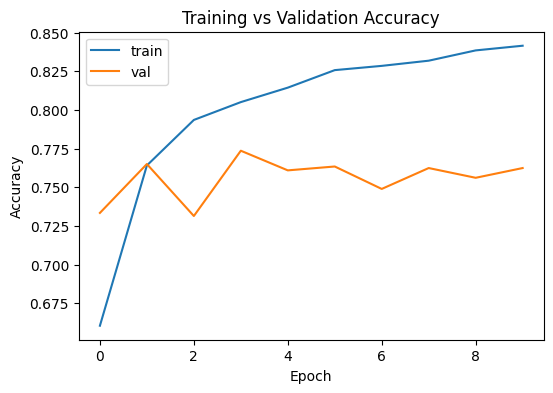

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The chart clearly **shows overfitting** because the blue line (training accuracy) continues to rise, while the orange line (validation accuracy) flattens and starts to fluctuate around 0.75 after Epoch 3. This increasing gap means the model is only memorizing the training data instead of learning general rules. Consequently, running for more epochs will not improve the model's performance on new data. 

**To fix this, we can stop the training early (e.g., at Epoch 3) or use other techniques like Regularization or Dropout.**